# Seismic discontinuity attributes

Reminder: Art Barnes is required reading before jumping into attributes! Read this: https://csegrecorder.com/articles/view/too-many-seismic-attributes

## Load some seismic data

We'll use 1000 ms of the F3 seismic dataset. It's 459MB, sampled at 4 ms.

To get the data on Mac or Linux you can do this right from a Jupyter Notebook:

    ! wget -O ../data/F3_16-bit_int.sgy https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy

On Windows, you can [visit the URL by clicking here](https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy) (which will download the file) then move it to the `data` directory.

In [1]:
import numpy as np
import segyio

ds = np.DataSource('../data')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy'

with segyio.open(ds.open(url).name) as s:
    seismic = segyio.cube(s)
    
# Volume is int16. Turn it into floats.
seismic = (seismic / np.max(np.abs(seismic))).astype(float)
    
seismic.shape

(651, 951, 251)

In [2]:
seismic.dtype

dtype('float64')

In [3]:
import numpy as np

ma = np.percentile(seismic, 99.95)

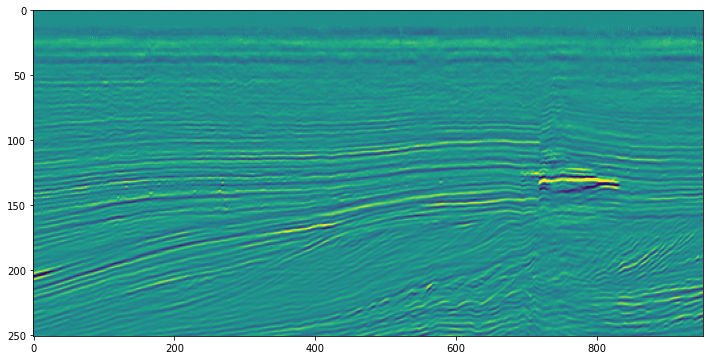

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(seismic[100].T, aspect='auto', vmin=-ma, vmax=ma)

## Similarity

Seismic similarity attributes, such as coherence and semblance, etc, are extremely useful attributes. In terma so freadin matter, you can't do better than [Joe Kington's 2015 Leading Edge tutorial](https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/writeup.md) on this topic. [Here's the Notebook.](https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/Discontinuity_tutorial.ipynb). We'll lean heavily on Joe's work here.

Joe uses a `moving_window` function to take a function `func` and pass it pieces of data reshaped into some `window`. The task of passing the running window over our dataset is handed off to `scipy.ndimage.generic_filter`, which you can think of as taking care of the machinery of convolution, correlation, or other moving window algorithms. This way, we can focus on writing simple functions that deal with single 3D kernels one at a time.

In [5]:
# Decimated seismic sub-cube:
seismic_ = seismic[:200:3, 600::3, 75:175]

In [6]:
from scipy.ndimage import generic_filter

def moving_window(data, func, window):
    """
    Helper function for multi-trace attribute generation.
    This function applies a 3D function func to process a
    region of shape `window` over a dataset `data`.
    """
    wrapped = lambda x: func(x.reshape(window))
    return generic_filter(data, wrapped, window)

## The original approach

We'll look first at Marfurt et al's (1999) extension of Bahorich & Farmer's original cross-correlation approach:

In [7]:
def marfurt_semblance(region):
    """
    Marfurt, K., V. Sudhaker, A. Gersztenkorn, K. D. Crawford, and S. E. Nissen, 1999,
    Coherency calculations in the presence of structural dip: GEOPHYSICS, 64, 104-111.
    doi:10.1190/1.1444508
    """
    i, x, t = region.shape
    region = region.reshape(-1, t)
    square_sums = np.sum(region, axis=0)**2
    sum_squares = np.sum(region**2, axis=0)
    c = square_sums.sum() / (sum_squares.sum() + 1e-12)  # Divide by zero.
    return c / (i * x)

This takes 12.4 s on my computer:

In [10]:
semb = moving_window(seismic_, marfurt_semblance, (3, 3, 9))

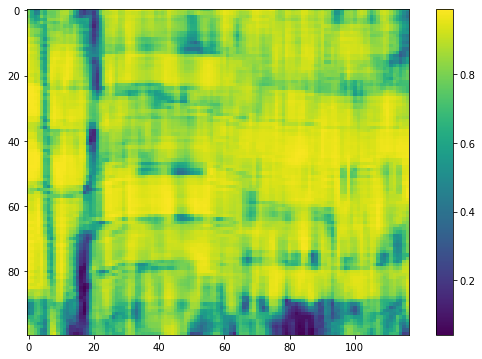

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(semb[50].T)
plt.colorbar(im)

One caveat to some similarity methods is that they're sensitive to lateral differences in amplitude as well as in phase. While this is desirable for detecting stratigraphic features, differences due amplitude can obscure subtle structural features. Gersztenkorn and Marfurt (1999) proposed an implementation that is sensitive only to lateral changes in phase of the input waveforms: _eigenstructure-based coherence_.

This computes the covariance matrix of the input region, similar to the previous example. However, it uses the ratio of the largest eigenvalue of the covariance matrix to the sum of the eigenvalues:

In [ ]:
def gersztenkorn(region):
    """
    Gersztenkorn, A., and K. J. Marfurt, 1999, Eigenstructure‐based coherence
    computations as an aid to 3-D structural and stratigraphic mapping:
    GEOPHYSICS, 64, 1468-1479. doi:10.1190/1.1444651
    """
    # Stack traces in 3D region into 2D array.
    region = region.reshape(-1, region.shape[-1])

    # Calculate eigenvalues of covariance matrix.
    cov = region.dot(region.T)
    vals = np.linalg.eigvalsh(cov)
    return vals.max() / (vals.sum() + 1e-12)

This takes 17.3 s on my computer:

In [13]:
semb = moving_window(seismic_, gersztenkorn, (3, 3, 9))

17.3 s ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


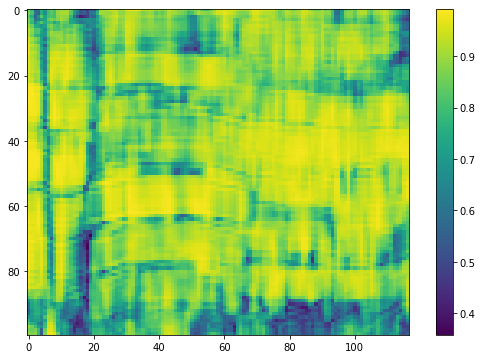

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(semb[50].T)
plt.colorbar(im)

An entirely different approach than any we've discussed so far is to apply a structure tensor to seismic attributes. The structure tensor measures how the gradient of each dimension co-varies locally. Randen et al. (2000) were the first to propose this approach in their Gradient Structure Tensor (GST) attributes. A number of useful attributes can be computed from the ratios of the eigenvalues of the structure tensor, one of which is a measure of how planar the data is locally, which we'll refer to as GST coherence (Randen, et al 2000) (Figure 1E).

In [15]:
from scipy.ndimage import gaussian_filter1d

def gradients(seismic, sigma):
    grads = []
    for axis in range(3):
        grad = gaussian_filter1d(seismic, sigma, axis=axis, order=1)
        grads.append(grad[..., np.newaxis])
    return np.concatenate(grads, axis=3)

def moving_window4d(grad, window, func):
    """Applies the given function *func* over a moving *window*, reducing 
    the input *grad* array from 4D to 3D."""
    # Pad in the spatial dimensions, but leave the gradient dimension unpadded.
    half_window = [(x // 2, x // 2) for x in window] + [(0, 0)]
    padded = np.pad(grad, half_window, mode='reflect')
    
    out = np.empty(grad.shape[:3], dtype=float)
    for i, j, k in np.ndindex(out.shape):
        region = padded[i:i+window[0], j:j+window[1], k:k+window[2], :]
        out[i,j,k] = func(region)
    return out

def gst_coherence_calc(region):
    region = region.reshape(-1, 3)
    gst = region.T.dot(region)
    eigs = np.sort(np.linalg.eigvalsh(gst))[::-1]
    return (eigs[0]-eigs[1]) / (eigs[0]+eigs[1])

def gst_coherence(seismic, window, sigma=1):
    """
    Randen, T., E. Monsen, C. Singe, A. Abrahamsen, J. Hansen, T. Saeter, and J. Schlaf, 2000,
    Three-dimensional texture attributes for seismic data analysis, 70th Annual International Meeting,
    SEG, Expanded Abstracts, 668-671.
    """
    grad = gradients(seismic, sigma)
    return moving_window4d(grad, window, gst_coherence_calc)

This takes 13.8 s on my computer:

In [20]:
semb = gst_coherence(seismic_, (3, 3, 9))

13.8 s ± 284 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


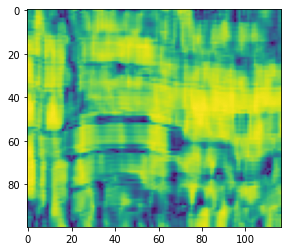

In [18]:
plt.imshow(semb[50].T)